In [1]:
#@title A demonstration of a integration of a process model and simple reservoir model
#@markdown This is a demo of how reservoir simulation can be intergrated into process simulation.
#@markdown <br><br>This document is part of the module ["Introduction to Gas Processing using NeqSim in Colab"](https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/examples_of_NeqSim_in_Colab.ipynb#scrollTo=_eRtkQnHpL70).
#%%capture
!pip install neqsim
import neqsim
from neqsim.thermo.thermoTools import *

from neqsim.process import openprocess
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
plt.style.use('classic')
%matplotlib inline

     |████████████████████████████████| 55.9 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 64.1 MB/s 


#Setting up a reservoir model
We start by establishing a simple reservoir model with gas injector and water injection

In [2]:
from neqsim.process.processTools import simplereservoir,clearProcess,runProcess, getProcess

fluid1 = fluid('srk')
fluid1.addComponent("nitrogen", 0.100)
fluid1.addComponent("CO2", 0.100)
fluid1.addComponent("methane", 30.00)
fluid1.addComponent("ethane", 1.0)
fluid1.addComponent("propane", 1.0)
fluid1.addComponent("i-butane", 1.0)
fluid1.addComponent("n-butane", 1.0)
fluid1.addComponent("n-hexane", 0.1)
fluid1.addComponent("n-heptane", 0.1)
fluid1.addComponent("n-nonane", 1.0)
fluid1.addComponent("nC10", 1.0)
fluid1.addComponent("nC12", 3.0)
fluid1.addComponent("nC15", 3.0)
fluid1.addComponent("nC20", 3.0)
fluid1.addComponent("water", 11.0)
fluid1.setMixingRule(2)
fluid1.setMultiPhaseCheck(True)

fluid1.setPressure(100.0, 'bara')
fluid1.setTemperature(100.0, 'C')

TPflash(fluid1)

clearProcess()
reservoirOps = simplereservoir(fluid1, "Well 1 reservoir", gasvolume=5.0 * 1e7, oilvolume=552.0 * 1e6, watervolume=10.0e6)

#producedGasStream = reservoirOps.addGasProducer("SLP_A32562G")
#producedGasStream.setFlowRate(0.01, "MSm3/day")

#injectionGasStream = reservoirOps.addGasInjector("SLP_A32562GI")
#fluidComposition(injectionGasStream.getFluid(), [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,0.0])
#njectionGasStream.setFlowRate(1.1, "MSm3/day")

#injectionWaterStream = reservoirOps.addWaterInjector("SLP_A32562W")
#injectionWaterStream.setFlowRate(10000000.1, "kg/day")

producedOilStream = reservoirOps.addOilProducer("SLP_A32562O")
producedOilStream.setFlowRate(50000000.0, "kg/day")
runProcess()
getProcess().save('reservoir.neqsim')

# Establish the oil and gas process
A simple oil and gas process is established

In [10]:
from neqsim.process.processTools import valve,stream,simplereservoir,clearProcess,runProcess, getProcess,separator3phase,heater,separator,compressor,setpoint,recycle,mixer

fluid3 = fluid1.clone()

clearProcess()
wellStream = stream(fluid3)
wellStream.setName("well stream")
wellStream.setFlowRate(14.23, "MSm3/day")
wellStream.setTemperature(40.0, "C")
wellStream.setPressure(120.0, "bara")

wellvalve = heater(wellStream)
wellvalve.setName("well stream cooler/heater")
wellvalve.setOutPressure(62.21)
wellvalve.setOutTemperature(273.15+35.21);

wellvalve = valve(wellStream)
wellvalve.setName("inlet choke valve")
wellvalve.setOutletPressure(52.21);

inletSeparator = separator3phase(wellvalve.getOutStream())
inletSeparator.setName("1st stage separator")

oilToInletSep = stream(fluid3.clone())
oilToInletSep.setFlowRate(1e-10, "kg/hr")
inletSeparator.addStream(oilToInletSep)

valve2 = valve(wellStream)#inletSeparator.getGasOutStream())
valve2.setName("oil HP to MP valve");
valve2.setOutletPressure(15.0);

cooler1 = heater(valve2.getOutStream())
cooler1.setName("oil cooler/heater to 2nd stage")
cooler1.setOutTemperature(323.15)

waterDPvalve =  valve(inletSeparator.getWaterOutStream())
waterDPvalve.setName("Water HP to LP valve")
waterDPvalve.setOutletPressure(1.01325)

waterStabSep = separator(waterDPvalve.getOutStream())
waterStabSep.setName('water degasing separator"')

waterToTreatment = stream(waterStabSep.getLiquidOutStream())
waterToTreatment.setName("water to treatment")
		
mpseparator = separator3phase(cooler1.getOutStream())
mpseparator.setName("2nd stage separator")

oilToSep = stream(fluid3.clone())
oilToSep.setFlowRate(1e-10, "kg/hr")
mpseparator.addStream(oilToSep)

valvempValve = valve(mpseparator.getOilOutStream())
valvempValve.setName("oil MP to LP valve")
valvempValve.setOutletPressure(2.8)

lpseparator = separator3phase(valvempValve.getOutStream())
lpseparator.setName("3rd stage separator")

stableOilStream  = stream(lpseparator.getOilOutStream())
stableOilStream.setName("stable oil")
		
lpcompressor = compressor(lpseparator.getGasOutStream())
lpcompressor.setName("1st stage recompressor");
compressorPresSet2 =  setpoint("comp pres LP set", lpcompressor, "pressure",valve2.getOutStream());

lpgasheater = heater(lpcompressor.getOutStream())
lpgasheater.setName('1st stage gas heat exchanger')
lpgasheater.setOutTemperature(290.0)

lpscrubber = separator(lpgasheater.getOutStream())
lpscrubber.setName("2nd stage scrubber")
liqFromlpscrubber = lpscrubber.getLiquidOutStream()

lpscrubberResyc = recycle(liqFromlpscrubber)
lpscrubberResyc.setName("mpscrubberRes")
lpscrubberResyc.setOutletStream(oilToSep)

mixermp = mixer("mp gas mixer")
mixermp.addStream(lpscrubber.getGasOutStream())
mixermp.addStream(mpseparator.getGasOutStream())

compressor2stage = compressor(mixermp.getOutStream())
compressor2stage.setName("2nd stage recompressor")

compressorPresSet = setpoint("comp pres set", compressor2stage, "pressure",inletSeparator)
		
secondndstagecooler = heater(compressor2stage.getOutStream())
secondndstagecooler.setName("2nd stage cooler")
secondndstagecooler.setOutTemperature(290.0)

scrubbberfrom2ndstage = separator(secondndstagecooler.getOutStream())
scrubbberfrom2ndstage.setName("scrubber of mix gas HP")

mixer = mixer("HP rich gas mixer")
mixer.addStream(inletSeparator.getGasOutStream())
mixer.addStream(scrubbberfrom2ndstage.getGasOutStream())

dewPointScrubberCooler = heater(mixer.getOutStream())
dewPointScrubberCooler.setName("dew point scrubber cooler2")
dewPointScrubberCooler.setOutTemperature(273.15+32.3)

mpscrubber = separator(dewPointScrubberCooler.getOutStream())
mpscrubber.setName("dew point control scrubber")

liqFrommpscrubber = mpscrubber.getLiquidOutStream()

mpscrubberResyc = recycle(liqFrommpscrubber)
mpscrubberResyc.setName("hpscrubberRes")
mpscrubberResyc.addStream(scrubbberfrom2ndstage.getLiquidOutStream())
mpscrubberResyc.setOutletStream(oilToSep)

exportCompressor = compressor(mpscrubber.getGasOutStream())
exportCompressor.setName("export compressor")
exportCompressor.setOutletPressure(150.0)

exportCooler = heater(exportCompressor.getOutStream())
exportCooler.setName('export cooler')
exportCooler.setOutTemperature(30.0, 'C')

richGas = stream(exportCooler.getOutStream())
richGas.setName("rich gas")
getProcess().save('gasprocess.neqsim')

# Running the combined reservoir and process model
Importing reservoir simulation ad process simulation and running simlation



sim year  0.0
sim year  1.0
sim year  2.0
sim year  3.0
sim year  4.0
sim year  5.0
sim year  6.0
sim year  7.0
sim year  8.0
sim year  9.0
sim year  10.0
sim year  11.0
sim year  12.0
sim year  13.0
sim year  14.0
sim year  15.0
sim year  16.0
sim year  17.0
sim year  18.0
sim year  19.0
sim year  20.0
sim year  21.0
sim year  22.0
sim year  23.0
sim year  24.0
sim year  25.0
sim year  26.0
sim year  27.0


Text(0, 0.5, 'Rich Gas FLow [MSm3/day]')

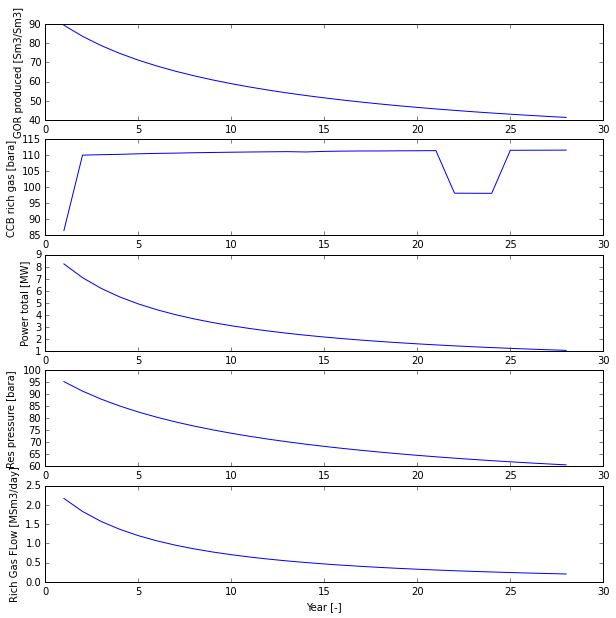

In [11]:
from neqsim.process import getProcess, openprocess
import matplotlib.pyplot as plt
resmodel = openprocess('reservoir.neqsim')

reservoir = resmodel.getUnit('Well 1 reservoir')
wellStream = reservoir.getOilProducer(0).getStream()

initPressure = resmodel.getUnit('Well 1 reservoir').getReservoirFluid().getPressure('bara')
wellStream.setFlowRate(30000000.0*resmodel.getUnit('Well 1 reservoir').getReservoirFluid().getPressure('bara')/initPressure, "kg/day")

deltat = 24*60*60.0*365
resmodel.setTimeStep(deltat)

GasOilProcess = openprocess('gasprocess.neqsim')
GasOilProcess.getUnit("well stream").setStream(wellStream)
GasOilProcess.getUnit("well stream cooler/heater").setOutTemperature(66.0, "C")
GasOilProcess.getUnit("well stream cooler/heater").setOutPressure(52.21, "bara")
GasOilProcess.getUnit("inlet choke valve").setOutletPressure(51.21, "bara")
GasOilProcess.getUnit("oil HP to MP valve").setOutletPressure(15.0, "bara")
GasOilProcess.getUnit("oil cooler/heater to 2nd stage").setOutTemperature(85.0, "C")
GasOilProcess.getUnit("oil MP to LP valve").setOutletPressure(1.8, "bara")
GasOilProcess.getUnit("Water HP to LP valve").setOutletPressure(1.01325, "bara")
GasOilProcess.getUnit("dew point scrubber cooler2").setOutTemperature(33.0, "C")
GasOilProcess.getUnit("2nd stage cooler").setOutTemperature(33.0, "C")
GasOilProcess.getUnit("1st stage gas heat exchanger").setOutTemperature(33.0, "C")
GasOilProcess.getUnit("1st stage recompressor").setIsentropicEfficiency(0.75)
GasOilProcess.getUnit("2nd stage recompressor").setIsentropicEfficiency(0.75)

time = []
pressure = []
GORprocess = []
cricondenbarrichgas = []
power = []
richGasFLowMSm3day = []

for step in range(28):
    print('sim year ' , reservoir.getTime()/(60.0*60*24*365))
    wellStream.setFlowRate(40000000.0*(resmodel.getUnit('Well 1 reservoir').getReservoirFluid().getPressure('bara')- GasOilProcess.getUnit("inlet choke valve").getOutStream().getPressure('bara'))/initPressure, "kg/day")
    resmodel.runTransient()
    GasOilProcess.run()
    time.append(reservoir.getTime()/(60.0*60*24*365))
    inlet_pressure = GasOilProcess.getUnit("inlet choke valve").getOutStream().getPressure('bara')
    GOR=GasOilProcess.getUnit("rich gas").getFluid().getFlowRate("Sm3/hr")/GasOilProcess.getUnit("stable oil").getFluid().getFlowRate("m3/hr")
    GORprocess.append(GOR)
    cricondenbarrichgas.append(GasOilProcess.getUnit("rich gas").CCB("bara"))
    power.append(GasOilProcess.getPower("W")/1.0e6)
    pressure.append(resmodel.getUnit('Well 1 reservoir').getReservoirFluid().getPressure('bara'))
    richGasFLowMSm3day.append(GasOilProcess.getUnit("rich gas").getFluid().getFlowRate("MSm3/day"))


plt.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
plt.subplot(5, 1, 1)
plt.plot(time, GORprocess)
plt.xlabel('Year [-]')
plt.ylabel('GOR produced [Sm3/Sm3]')
plt.subplot(5, 1, 2)
plt.plot(time, cricondenbarrichgas)
plt.xlabel('Year [-]')
plt.ylabel('CCB rich gas [bara]')
plt.subplot(5, 1, 3)
plt.plot(time, power)
plt.xlabel('Year [-]')
plt.ylabel('Power total [MW]')
plt.subplot(5, 1, 4)
plt.plot(time, pressure)
plt.xlabel('Year [-]')
plt.ylabel('Res pressure [bara]')
plt.subplot(5, 1, 5)
plt.plot(time, richGasFLowMSm3day)
plt.xlabel('Year [-]')
plt.ylabel('Rich Gas FLow [MSm3/day]')


In [12]:
#Read results of last year
GasLiqidRatio = GasOilProcess.getUnit("rich gas").getFluid().getFlowRate("Sm3/hr")/GasOilProcess.getUnit("stable oil").getFluid().getFlowRate("m3/hr")
compressorPower1 = GasOilProcess.getUnit("1st stage recompressor").getPower()/1.0e3
compressorPower2 = GasOilProcess.getUnit("2nd stage recompressor").getPower()/1.0e3
exportCompressorPower = GasOilProcess.getUnit("export compressor").getPower()/1.0e3
cooler1Duty = GasOilProcess.getUnit("1st stage gas heat exchanger").getDuty()/1e3
cooler2Duty = GasOilProcess.getUnit("2nd stage cooler").getDuty()/1e3

wellStreamFLowMSm3day = GasOilProcess.getUnit("well stream").getFluid().getFlowRate("MSm3/day")
richGasFLowMSm3day = GasOilProcess.getUnit("rich gas").getFluid().getFlowRate("MSm3/day")
gasInletSepFlowMSm3day = GasOilProcess.getUnit("1st stage separator").getGasOutStream().getFluid().getFlowRate("MSm3/day")
stableOilFLowm3hr = GasOilProcess.getUnit("stable oil").getFluid().getFlowRate("m3/hr")
waterToTreatmentRatem3hr = GasOilProcess.getUnit("water to treatment").getFluid().getFlowRate("m3/hr")
resycleFLowDewPointScrubber = GasOilProcess.getUnit("dew point control scrubber").getLiquidOutStream().getFluid().getFlowRate("kg/hr")
GOR=GasOilProcess.getUnit("rich gas").getFluid().getFlowRate("Sm3/hr")/ GasOilProcess.getUnit("stable oil").getFluid().getFlowRate("m3/hr")
TVPofexportoil = GasOilProcess.getUnit("stable oil").TVP(30.0, "C")
CCB_exportgas = GasOilProcess.getUnit("rich gas").CCB("bara")
CCT_exportgas = GasOilProcess.getUnit("rich gas").CCT("C")

print("rich gas flow", richGasFLowMSm3day, " MSm3/day")
print("1st stage recompressor power", compressorPower1, " kW")
print("2nd stage recompressor power", compressorPower2, " kW")
print("export compressor power", exportCompressorPower, " kW")
print("1st stage gas cooler duty ", cooler1Duty, " kW")
print("2nd stage cooler duty ", cooler2Duty, " kW")
print("stable oil production ", stableOilFLowm3hr, " m3/hr")
print("rich gas production ", richGasFLowMSm3day, " MS3/day")
print("GOR ", GOR)
print("TVP of export oil ", TVPofexportoil)
print("cricondenbar pressure of rich gas ", CCB_exportgas, " bara")
print("cricondentherm temperature of rich gas ", CCT_exportgas, " C")

rich gas flow 0.20337760034066718  MSm3/day
1st stage recompressor power 330.1543169814121  kW
2nd stage recompressor power 454.4312039996651  kW
export compressor power 260.5351551251545  kW
1st stage gas cooler duty  -860.439513915694  kW
2nd stage cooler duty  -882.3339128935015  kW
stable oil production  204.96791547277678  m3/hr
rich gas production  0.20337760034066718  MS3/day
GOR  41.34338128635859
TVP of export oil  0.9170971481260098
cricondenbar pressure of rich gas  111.6074943841131  bara
cricondentherm temperature of rich gas  33.052697596546125  C
